# Sentinel-SLM: Comprehensive Exploratory Data Analysis (EDA)

**Objective:** Analyze the distribution, balance, and linguistic properties of the aggregated Sentinel-SLM dataset (1.6M+ samples) across 8 safety categories.

**Dataset:** `data/processed/final_augmented_dataset_enriched.parquet` (or standard version)

In [20]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load Data (Prefer Enriched)
ENRICHED_PATH = "../data/processed/final_augmented_dataset_enriched.parquet"
STANDARD_PATH = "../data/processed/final_augmented_dataset.parquet"

if os.path.exists(ENRICHED_PATH):
    DATA_PATH = ENRICHED_PATH
    print(f"🔹 Loading Enriched Dataset: {ENRICHED_PATH}")
else:
    DATA_PATH = STANDARD_PATH
    print(f"🔸 Loading Standard Dataset: {STANDARD_PATH}")

try:
    df = pd.read_parquet(DATA_PATH)
    print(f"✅ Loaded {len(df):,} samples.")
except FileNotFoundError:
    print("❌ Dataset not found. Run pipeline or enrichment first.")

🔹 Loading Enriched Dataset: ../data/processed/final_augmented_dataset_enriched.parquet
✅ Loaded 1,671,001 samples.


## 1. Source Distribution
Where is the data coming from? Visualizing the contribution of KoalaAI vs. others.

source
koala_multilingual    1459350
civil_comments         180487
beaver_tails            27186
damo_multijail           3778
jailbreak_bench           200
Name: count, dtype: int64


/var/folders/hb/wpy720m57q9gbm2kt5l0_j640000gn/T/ipykernel_97953/3597870513.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.index, y=source_counts.values, palette="viridis")


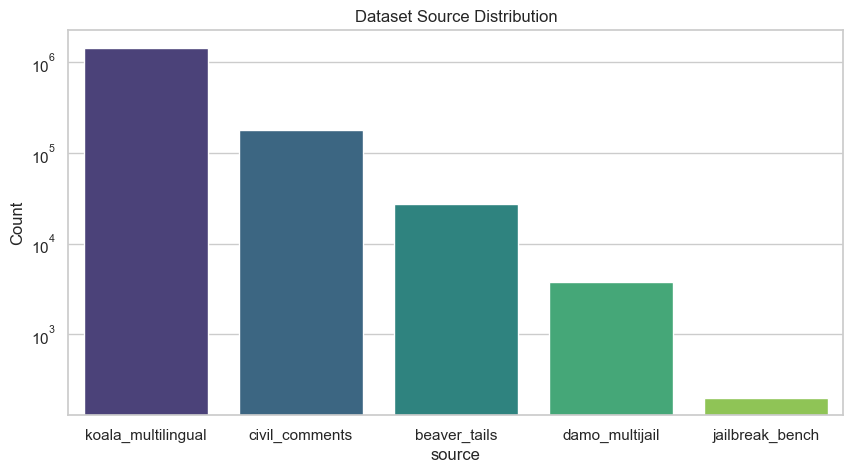

In [21]:
source_counts = df['source'].value_counts()
print(source_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=source_counts.index, y=source_counts.values, palette="viridis")
plt.title("Dataset Source Distribution")
plt.ylabel("Count")
plt.yscale('log')  # Log scale due to KoalaAI dominance
plt.show()

## 2. Category Balance (The 8 Taxonomy Classes)
Are we balanced? (Spoiler: 'Safe' is usually dominant).

/var/folders/hb/wpy720m57q9gbm2kt5l0_j640000gn/T/ipykernel_97953/3879942849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=label_counts.index, x=label_counts.values, orient='h', palette="magma")


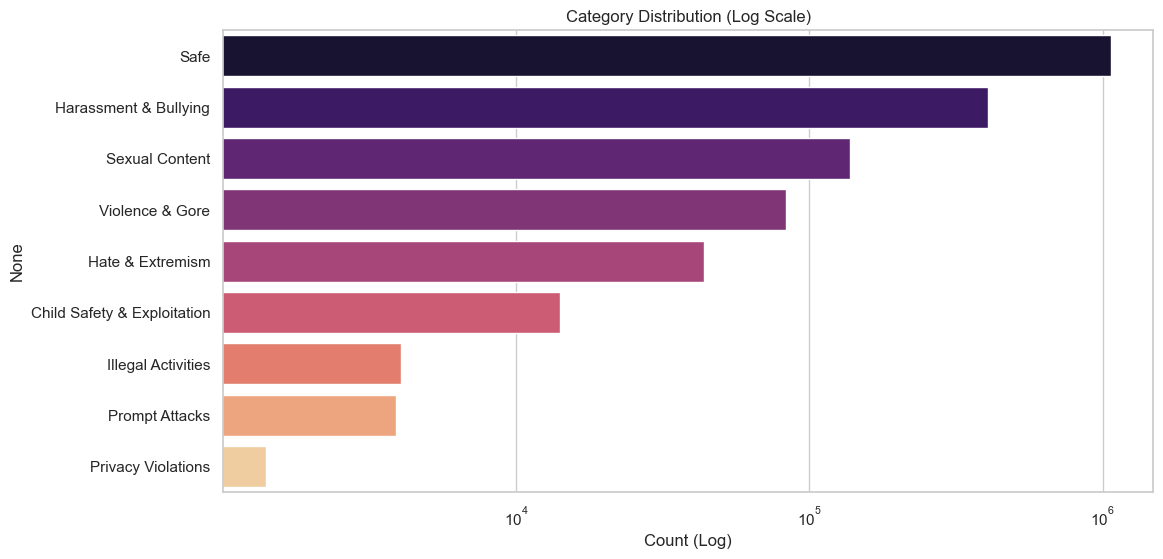

Exact Counts:
Safe                           1069901
Harassment & Bullying           407601
Sexual Content                  138072
Violence & Gore                  83339
Hate & Extremism                 43841
Child Safety & Exploitation      14121
Illegal Activities                4035
Prompt Attacks                    3878
Privacy Violations                1397
Name: count, dtype: int64


In [22]:
from src.sentinel.utils.taxonomy import CATEGORY_NAMES

# Flatten labels
all_labels = [label for sublist in df['labels'] for label in sublist]
label_counts = pd.Series(all_labels).map(CATEGORY_NAMES).value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(y=label_counts.index, x=label_counts.values, orient='h', palette="magma")
plt.title("Category Distribution (Log Scale)")
plt.xscale('log')
plt.xlabel("Count (Log)")
plt.show()

print("Exact Counts:")
print(label_counts)

## 3. Class Imbalance Ratio
Checking which categories are under-represented.

In [23]:
majority_class = label_counts.max()
imbalance_ratios = majority_class / label_counts
print("Imbalance Ratios (1 = Majority):")
print(imbalance_ratios.sort_values(ascending=False))

Imbalance Ratios (1 = Majority):
Privacy Violations             765.856120
Prompt Attacks                 275.889892
Illegal Activities             265.155143
Child Safety & Exploitation     75.766660
Hate & Extremism                24.404119
Violence & Gore                 12.837939
Sexual Content                   7.748863
Harassment & Bullying            2.624873
Safe                             1.000000
Name: count, dtype: float64


## 4. Text Length Analysis
SLMs have limited context windows. How long are the inputs?

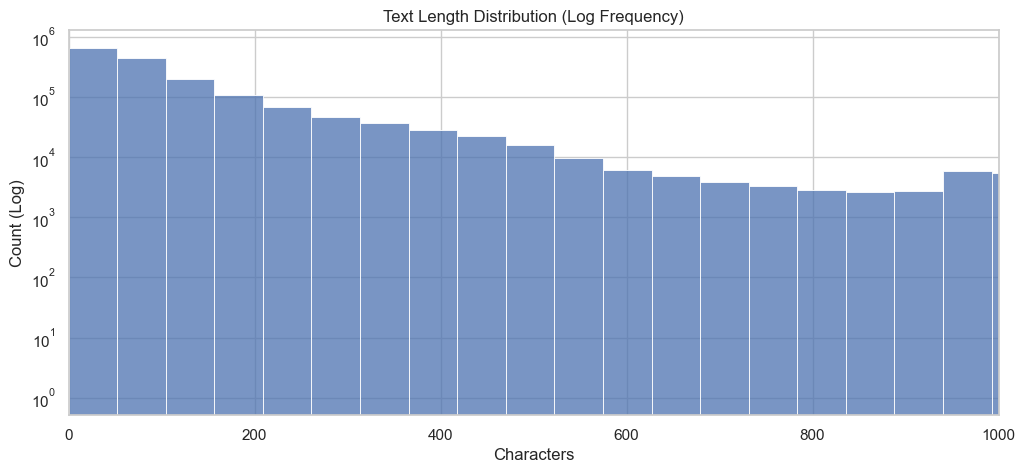

Length Stats:
count    1.671001e+06
mean     1.235542e+02
std      1.534950e+02
min      0.000000e+00
25%      3.600000e+01
50%      6.800000e+01
75%      1.420000e+02
max      5.224000e+03
Name: char_length, dtype: float64


In [24]:
# Calculate length, dropping NaNs/empty strings just in case
df['char_length'] = df['text'].astype(str).str.len()
valid_lengths = df['char_length'].dropna()

plt.figure(figsize=(12, 5))
# Use simple bins and log scale on Y axis manually for robustness
sns.histplot(valid_lengths, bins=100, kde=False)
plt.title("Text Length Distribution (Log Frequency)")
plt.xlabel("Characters")
plt.ylabel("Count (Log)")
plt.yscale('log') 
plt.xlim(0, 1000) # Zoom in on typical range
plt.show()

print("Length Stats:")
print(valid_lengths.describe())

## 5. Language Distribution
Analyzing multilingual spread.

🔹 Using pre-calculated 'lang' column.
lang
en    486078
ru     85976
uk     78868
ja     77437
zh     77428
de     75967
es     74908
it     73274
ko     73247
fr     72999
pl     70989
kk     69290
fi     69020
cs     66454
be     66454
sv     64975
lv     63501
pt      2521
nl      1400
no      1334
Name: count, dtype: int64


/var/folders/hb/wpy720m57q9gbm2kt5l0_j640000gn/T/ipykernel_97953/3301771559.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="coolwarm")


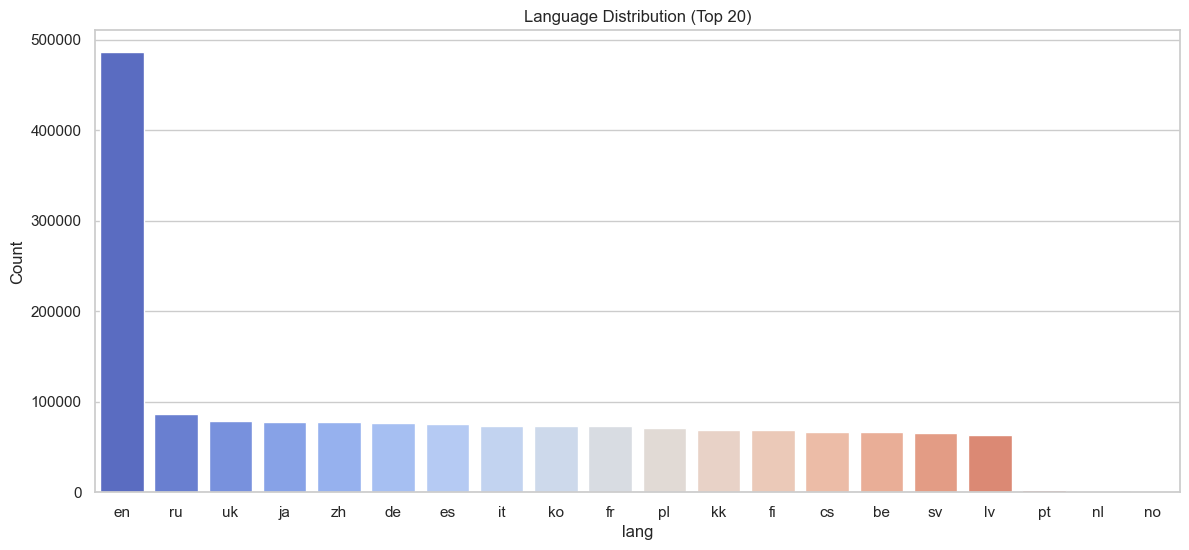

In [25]:
if 'lang' in df.columns:
    print("🔹 Using pre-calculated 'lang' column.")
    lang_counts = df['lang'].value_counts().head(20)
else:
    print("🔸 'lang' column not found. Estimating on sample (slow)...")
    try:
        from langdetect import detect
        def safe_detect(text):
            try: return detect(text)
            except: return "unknown"
        sample_df = df.sample(n=5000, random_state=42)
        lang_counts = sample_df['text'].apply(lambda x: safe_detect(str(x)[:500])).value_counts().head(20)
    except ImportError:
        print("langdetect not found. Run 'pip install langdetect'")
        lang_counts = pd.Series([])

print(lang_counts)

if not lang_counts.empty:
    plt.figure(figsize=(14, 6))
    sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="coolwarm")
    plt.title("Language Distribution (Top 20)")
    plt.ylabel("Count")
    plt.show()